In [58]:
import keras
import tensorflow as tf
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

print(keras.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.4.3
Num GPUs Available:  1


In [59]:
dataset_folder = "../datasets"

emotions = ["angry", "fearful", "happy", "neutral", "sad", "surprised"]
datasets = ["denisleu", "ExpwCleaned", "Fer Affectnet"]

X = []
y = []

IMG_SIZE = 96
class_counts = {}
TARGET_SIZE = (IMG_SIZE, IMG_SIZE)

num_classes = len(emotions)
for dataset in tqdm(datasets):
    for emotion in emotions:
        path = os.path.join(dataset_folder, dataset, emotion)
        if not os.path.exists(path):
            continue
        
        images = os.listdir(path)
        if not emotion in class_counts:
            class_counts[emotion] = 0
        
        for img in images:
            img_path = os.path.join(path, img)
            class_counts[emotion] = class_counts[emotion] + len(images)
            img = Image.open(img_path).convert('L')
            img = img.resize(TARGET_SIZE, Image.BILINEAR)
            img = np.array(img, dtype=np.uint8)
            img = np.reshape(img, (IMG_SIZE, IMG_SIZE, 1))
            
            one_hot_label = to_categorical(emotions.index(emotion), num_classes=num_classes)
            X.append(img)
            y.append(one_hot_label)
            
X = np.array(X) / 255.0
y = np.array(y)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:18<00:00,  6.11s/it]


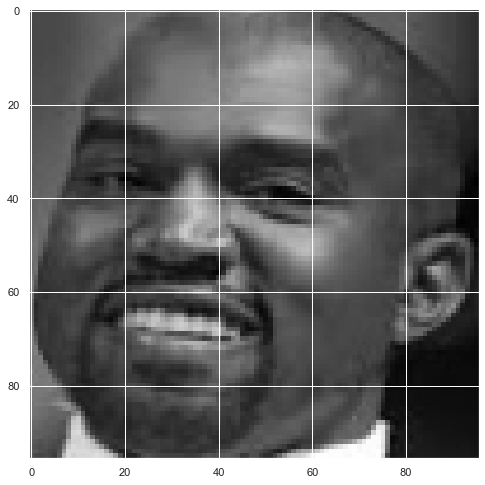

happy


In [60]:
plt.imshow(X[5], cmap="gray")
plt.show()
print(emotions[np.argmax(y[5])])

In [61]:
model = Sequential([
    Conv2D(32, kernel_size=3, activation='relu', 
           input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),

    Conv2D(64, (3,3), activation="relu"),
    BatchNormalization(),
    Conv2D(64, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),

    Conv2D(128, (3,3), activation="relu"),
    BatchNormalization(),
    Conv2D(128, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.6),

    Conv2D(256, (3,3), activation="relu"),
    BatchNormalization(),
    Conv2D(256, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(emotions), activation='softmax'),
])
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_56 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
batch_normalization_57 (Batc (None, 45, 45, 64)        256       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 43, 43, 64)       

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 26019
Test size: 6505


In [63]:
class_weights = {emotions[i]:0 for i in range(len(emotions))}
for y in y_train:
    class_weights[emotions[np.argmax(y)]] += 1
class_weights = [len(y_train) / (len(emotions) *count) for count in class_weights.values()]
class_weights = {i:class_weights[i] for i in range(len(class_weights))}
class_weights

{0: 0.6916267942583733,
 1: 1.6919625438938743,
 2: 0.8280504105403858,
 3: 1.0571672354948805,
 4: 1.2609770282058739,
 5: 0.9837794918330308}

In [64]:
from datetime import datetime
logdir="../logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


In [81]:
BATCH_SIZE = 512
EPOCHS = 50
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    class_weight=class_weights,
                    callbacks=[tensorboard_callback],
                    validation_data=(X_test, y_test))

Epoch 1/50
51/51 [==============================] - 45s 768ms/step - loss: 0.4254 - accuracy: 0.8731 - val_loss: 0.5975 - val_accuracy: 0.8037
Epoch 2/50
51/51 [==============================] - 24s 464ms/step - loss: 0.4181 - accuracy: 0.8757 - val_loss: 0.5976 - val_accuracy: 0.8052
Epoch 3/50
51/51 [==============================] - 22s 437ms/step - loss: 0.4060 - accuracy: 0.8801 - val_loss: 0.5977 - val_accuracy: 0.8069
Epoch 4/50
51/51 [==============================] - 23s 458ms/step - loss: 0.4002 - accuracy: 0.8821 - val_loss: 0.5999 - val_accuracy: 0.8051
Epoch 5/50
51/51 [==============================] - 26s 476ms/step - loss: 0.4023 - accuracy: 0.8814 - val_loss: 0.5982 - val_accuracy: 0.8068
Epoch 6/50
51/51 [==============================] - 28s 547ms/step - loss: 0.4040 - accuracy: 0.8789 - val_loss: 0.5987 - val_accuracy: 0.8055
Epoch 7/50
51/51 [==============================] - 22s 425ms/step - loss: 0.4009 - accuracy: 0.8799 - val_loss: 0.5997 - val_accuracy: 0.8052

In [82]:
predictions = model.predict(X_test)

In [83]:
from sklearn.metrics import accuracy_score
print(f"Train accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))}")

Train accuracy: 0.8061491160645657


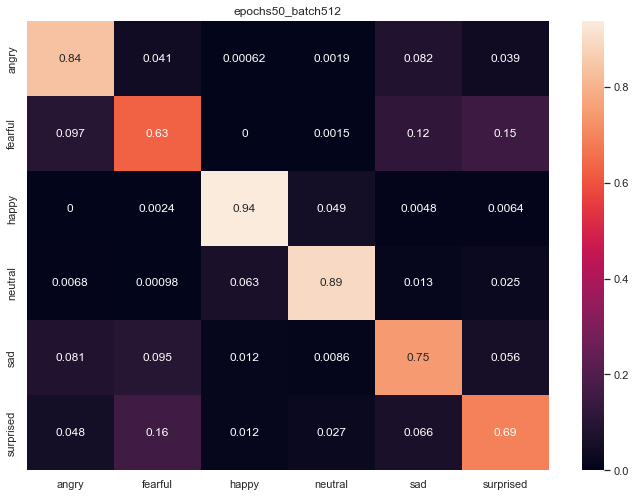

In [84]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), normalize="true")
import seaborn as sn
sn.set(rc={'figure.figsize':(11.7, 8.27)})
sn.heatmap(cm, annot=True, xticklabels=emotions, yticklabels=emotions).set_title(f'epochs{EPOCHS}_batch{BATCH_SIZE}')
plt.show()

In [74]:
MODEL_SAVE_DIR = "../saved_models/basicCnn"
def save(model, name):
  index = 0
  pth = os.path.join(MODEL_SAVE_DIR, f"{name}_{EPOCHS}_{BATCH_SIZE}-{str(index)}.h5")
  while os.path.exists(pth):
      index += 1
      pth = os.path.join(MODEL_SAVE_DIR, f"{name}_{EPOCHS}_{BATCH_SIZE}-{str(index)}.h5")
  model.save(pth)
  print(pth)
    
save(model, "basicCNN")

../saved_models/basicCnn\basicCNN_50_16-0.h5


In [ ]:
model = load_model('../saved_models/basicCnn/basicCNN_100_1000-0.h5')

In [ ]:
model.summary()